In [70]:
import pandas as pd
import matplotlib.pyplot as plt
#from sklearn.metrics import mean_absolute_error, mean_squared_error, roc_auc_score, classification_report
from sklearn.model_selection import train_test_split
import numpy as np
import torch
from torch.utils.data import TensorDataset, DataLoader
from sklearn.preprocessing import StandardScaler

dyadic = pd.read_csv('Dyadic_v25_1.csv')
aid = pd.read_csv('micFINAL.csv')
term = pd.read_csv('UCDPConflictTerminationDataset_v4_2024_Dyad.csv')

https://ucdp.uu.se/downloads/index.html#dyadic
https://ucdp.uu.se/downloads/monadterm/UCDPConflictTerminationDataset_v4_2024_Codebook.pdf
https://ucdp.uu.se/downloads/dyadic/ucdp-dyadic-251.pdf
https://ucdp.uu.se/downloads/aidmilc/ucdp_mic_codebook.pdf


Research Question: how do interstate conflicts evolve over time; what trends do we see with respect to region, motivations, and intensity? How do they end, and how do 3rd party interventions affect this process?



In [42]:
aid['start_year'] = pd.to_datetime(aid['start_event'], errors='coerce').dt.year
aid['end_year'] = pd.to_datetime(aid['end_event'], errors='coerce').dt.year
aid_types = ['peacekeeping', 'good_office', 'fact_finding', 'permanent_observers']
aid[aid_types].fillna(0)


# --- Expand to conflict-year level ---
aid_years = []
for _, row in aid.iterrows():
    if pd.notnull(row['start_year']) and pd.notnull(row['end_year']):
        for yr in range(int(row['start_year']), int(row['end_year']) + 1):
            entry = {
                'conflict_id': row['conflict_id'],
                'year': yr,
                'foreign_intervention': 1,
                'num_countries_aiding': row.get('third_states_no', 0)
            }
            # Add one-hot encoded type columns
            for col in aid_types:
                entry[col] = row.get(col, 0)
            aid_years.append(entry)


aid_expanded = pd.DataFrame(aid_years)
aid_expanded = aid_expanded.dropna(subset=['conflict_id']).copy()
cont_cols = [c for c in aid_expanded.columns if aid_expanded[c].dtype in ['float32','float64','int32','int64'] and c not in ['region_code'] ]
print('Summary stats for continuous columns:')
display(aid_expanded[cont_cols].describe().T)
aid_expanded['conflict_id'].nunique()

Summary stats for continuous columns:


,count,mean,std,min,25%,50%,75%,max
conflict_id,3527.0,129.144032,44.356733,86.0,90.0,113.0,146.0,255.0
year,3527.0,2001.273887,3.823511,1992.0,1999.0,2001.0,2004.0,2011.0
foreign_intervention,3527.0,1.000000,0.000000,1.0,1.0,1.0,1.0,1.0
num_countries_aiding,3527.0,0.819393,1.168449,0.0,0.0,1.0,1.0,17.0
peacekeeping,3527.0,0.038560,0.192570,0.0,0.0,0.0,0.0,1.0
good_office,3527.0,0.089311,0.285233,0.0,0.0,0.0,0.0,1.0
fact_finding,3527.0,0.019280,0.137526,0.0,0.0,0.0,0.0,1.0
permanent_observers,3527.0,0.011908,0.108488,0.0,0.0,0.0,0.0,1.0


29

In [43]:
for col in aid_types:
    if col not in aid_expanded.columns:
        aid_expanded[col] = 0
    aid_expanded[col] = pd.to_numeric(aid_expanded[col], errors='coerce').fillna(0).astype(int)

# aggregate with correct named-aggregation tuples
aid_expanded = (
    aid_expanded.groupby(['conflict_id', 'year'])
    .agg(
        foreign_intervention=('foreign_intervention', 'max'),
        num_countries_aiding=('num_countries_aiding', 'sum'),
        **{col: (col, 'sum') for col in aid_types},
    )
    .reset_index()
)

cont_cols = [c for c in aid_expanded.columns if aid_expanded[c].dtype in ['float32','float64','int32','int64'] and c not in ['region_code'] ]
print('Summary stats for continuous columns:')
display(aid_expanded[cont_cols].describe().T)
aid_expanded['conflict_id'].nunique()
aid_expanded.head(2)

Summary stats for continuous columns:


,count,mean,std,min,25%,50%,75%,max
conflict_id,200.0,149.380,48.650488,86.0,113.0,141.0,188.0,255.0
year,200.0,2000.670,4.791229,1992.0,1997.0,2001.0,2004.0,2011.0
foreign_intervention,200.0,1.000,0.000000,1.0,1.0,1.0,1.0,1.0
num_countries_aiding,200.0,14.450,25.968816,0.0,1.0,4.0,14.0,161.0
peacekeeping,200.0,0.680,1.206182,0.0,0.0,0.0,1.0,7.0
good_office,200.0,1.575,4.705858,0.0,0.0,0.0,1.0,49.0
fact_finding,200.0,0.340,1.127277,0.0,0.0,0.0,0.0,12.0
permanent_observers,200.0,0.210,0.824194,0.0,0.0,0.0,0.0,6.0


,conflict_id,year,foreign_intervention,num_countries_aiding,peacekeeping,good_office,fact_finding,permanent_observers
0,86.0,1996,1,6,0,0,0,0
1,86.0,1997,1,37,0,1,0,0


In [ ]:
dyadic['region_single'] = dyadic['region'].apply(lambda x: x.split(',')[0])

dyadic_yearly = (
    dyadic.groupby(['conflict_id', 'year'])
          .agg(
              battle_deaths = ('intensity_level', 'mean'),
              num_dyads     = ('dyad_id', 'nunique'),
              incompatibility_mode = ('incompatibility',
                                     lambda x: x.mode().iloc[0] if not x.mode().empty else np.nan),
              region = ('region_single',
                        lambda x: x.mode().iloc[0] if not x.mode().empty else x.iloc[0]),
              type_of_conflict = ('type_of_conflict',
                                  lambda x: x.mode().iloc[0] if not x.mode().empty else np.nan),
          )
          .reset_index()
)

# mark rows that were present (active) before filling the full grid
dyadic_yearly['active'] = 1

# build full conflict_id × year grid (1970-2022) and reindex
conflict_ids = dyadic_yearly['conflict_id'].unique()
years = list(range(1970, 2023))
full_index = pd.MultiIndex.from_product([conflict_ids, years], names=['conflict_id','year'])
dyadic_yearly = dyadic_yearly.set_index(['conflict_id','year']).reindex(full_index).reset_index()

# fill missing values with 0 (per your request)
dyadic_yearly = dyadic_yearly.fillna(0)

# compute yrs_since_last (years since previous active year; 0 if none or if active this year)
# and consec_years (consecutive active-year counter: 1 for first active year in a run, 0 for inactive)
def compute_gap_and_consec(g):
    last_active = None
    consec = 0
    yrs_since = []
    consecs = []
    for yr, active in zip(g['year'].tolist(), g['active'].tolist()):
        if int(active) == 1:
            if last_active is None or yr - last_active != 1:
                consec = 1
            else:
                consec += 1
            yrs_since.append(0)
            consecs.append(consec)
            last_active = yr
        else:
            yrs_since.append( yr - last_active if last_active is not None else 0 )
            consecs.append(0)
    g['yrs_since_last'] = yrs_since
    g['consec_years'] = consecs
    return g

dyadic_yearly = dyadic_yearly.groupby('conflict_id', group_keys=False).apply(compute_gap_and_consec)

# enforce integer types for the new counters
dyadic_yearly['yrs_since_last'] = dyadic_yearly['yrs_since_last'].astype(int)
dyadic_yearly['consec_years']   = dyadic_yearly['consec_years'].astype(int)
dyadic_yearly['active']         = dyadic_yearly['active'].astype(int)

# dyadic_yearly.head(2)

/var/folders/z7/9fstfdd508xf6mc6bvczb8dh0000gn/T/ipykernel_64493/872568718.py:75: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  dyadic_yearly = dyadic_yearly.groupby('conflict_id', group_keys=False).apply(compute_gap_and_consec)


In [45]:
# id_expanded = aid_expanded.dropna(subset=['conflict_id','year']).copy()
# aid_expanded['conflict_id'] = aid_expanded['conflict_id'].astype(int)
# aid_expanded['year'] = aid_expanded['year'].astype(int)

# keep = ['conflict_id','year','foreign_intervention','num_countries_aiding'] + aid_types
# for c in keep:
#     if c not in aid_expanded.columns:
#         aid_expanded[c] = 0

# dyadic_yearly = dyadic_yearly.merge(aid_expanded[keep], on=['conflict_id','year'], how='left')

# for c in ['foreign_intervention','num_countries_aiding'] + aid_types:
#     if c in dyadic_yearly.columns:
#         dyadic_yearly[c] = dyadic_yearly[c].fillna(0)
#         if c in aid_types + ['foreign_intervention']:
#             dyadic_yearly[c] = dyadic_yearly[c].astype(int)

# cont_cols = [c for c in dyadic_yearly.columns if dyadic_yearly[c].dtype in ['float32','float64','int32','int64'] and c not in ['region_code'] ]
# print('Summary stats for continuous columns:')
# display(dyadic_yearly[cont_cols].describe().T)

In [46]:
term_yearly = (
    term.groupby(['conflict_id', 'year'])
          .agg(
              battle_deaths = ('intensity_level', 'mean'),
              num_dyads     = ('dyad_id', 'nunique'),
              mode_outcome = ('d_outcome',
                lambda x: x.mode().iloc[0] if not x.mode().empty else np.nan)
          )
          .reset_index()
)

term_yearly = (
    term.groupby(['conflict_id', 'year'])
          .agg({
              'intensity_level': 'mean',     # total battle deaths that year
              'dyad_id': 'nunique',  # number of dyads active
          })
          .reset_index()
          .rename(columns={'best_est': 'battle_deaths'})
            .rename(columns={
              'best_est': 'battle_deaths',
              'dyad_id': 'num_dyads'
          })
)

merged = dyadic_yearly.merge( 
    term[['conflict_id', 'year' ,'d_ep_endyear','d_epterm']], 
    on=['conflict_id', 'year'],
    how='left')
merged['d_epterm'] = merged['d_epterm'].astype('float32')

df = merged.copy()
df = merged.dropna(subset=['d_epterm']).copy()
# Create integer codes for 'region' for embedding (reserve 0 for padding)
df['region_code'] = df['region'].astype('category').cat.codes + 1
num_regions = int(df['region_code'].max()) + 1  # includes padding id 0
print('num_regions (including padding):', num_regions)

df.head(3)

num_regions (including padding): 6


,conflict_id,year,battle_deaths,num_dyads,incompatibility_mode,region,type_of_conflict,active,yrs_since_last,consec_years,d_ep_endyear,d_epterm,region_code
274,205,1979,2.0,1.0,1.0,2,3.0,1,0,1,NaN,0.0,2
275,205,1980,2.0,1.0,1.0,2,3.0,1,0,2,NaN,0.0,2
276,205,1981,1.0,1.0,1.0,2,3.0,1,0,3,NaN,0.0,2


In [ ]:
# Continuous features (we will embed categorical 'region' separately)
features_cont = [
    'battle_deaths',
    'num_dyads',
    # 'num_countries_aiding',
    # 'foreign_intervention',
    # 'peacekeeping',
    # 'good_office',
    # 'fact_finding',
    # 'permanent_observers',
    'incompatibility_mode',
    'type_of_conflict',
]

target = 'd_epterm'

X_cont_seq, X_region_seq, y_labels = [], [], []

for conflict_id, group in df.groupby('region'):
    X_cont = group[features_cont].values.astype(np.float32)
    X_region = group['region_code'].values.astype(np.int64)
    y = group[target].values
    for t in range(len(X_cont) - 1):
        X_cont_seq.append(X_cont[:t+1])   # continuous features history
        X_region_seq.append(X_region[:t+1]) # categorical region history
        y_labels.append(y[t+1])


In [62]:
scaler = StandardScaler()
# Clean continuous sequences (replace NaNs with 0 for scaling step)
X_cont_clean = [np.nan_to_num(seq, nan=0.0) for seq in X_cont_seq]
all_steps = np.concatenate(X_cont_clean, axis=0) if len(X_cont_clean) > 0 else np.empty((0, len(features_cont)))
scaler.fit(all_steps)
X_cont_scaled = [scaler.transform(seq) for seq in X_cont_clean]

lengths = [len(s) for s in X_cont_seq]
MAXLEN = int(np.percentile(lengths, 95)) if len(lengths) > 0 else 1

# Pad continuous sequences (returns torch tensor)
X_cont_padded = pad_sequences_torch(X_cont_scaled, maxlen=MAXLEN)

# Pad categorical (region) sequences with padding id 0
def pad_cat(sequences, maxlen=MAXLEN, padding='pre', dtype=torch.long):
    padded = torch.zeros((len(sequences), maxlen), dtype=dtype)
    for i, seq in enumerate(sequences):
        seq = torch.tensor(seq, dtype=dtype)
        L = min(len(seq), maxlen)
        if padding == 'pre':
            padded[i, -L:] = seq[-L:]
        else:
            padded[i, :L] = seq[:L]
    return padded

X_region_padded = pad_cat(X_region_seq, maxlen=MAXLEN)
y_tensor = torch.tensor(y_labels, dtype=torch.float32)


In [63]:
# Split continuous, categorical, and labels together
X_train_cont, X_test_cont, X_train_cat, X_test_cat, y_train, y_test = train_test_split(
    X_cont_padded, X_region_padded, y_tensor, test_size=0.2, random_state=42
)


In [64]:
# Create datasets that include continuous and categorical tensors
train_ds = TensorDataset(X_train_cont, X_train_cat, y_train)
test_ds  = TensorDataset(X_test_cont, X_test_cat, y_test)

train_loader = DataLoader(train_ds, batch_size=64, shuffle=True)
test_loader  = DataLoader(test_ds, batch_size=64)



In [65]:
import torch.nn as nn

class LSTMWithEmb(nn.Module):
    def __init__(self, n_cont, num_regions, emb_dim=16, hidden_dim=64):
        super().__init__()
        self.embedding = nn.Embedding(num_regions, emb_dim, padding_idx=0)
        self.lstm = nn.LSTM(n_cont + emb_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, cont_x, cat_x):
        # cont_x: (batch, seq_len, n_cont), cat_x: (batch, seq_len)
        emb = self.embedding(cat_x)                       # (batch, seq_len, emb_dim)
        x = torch.cat([cont_x, emb], dim=2)             # concat features
        out, _ = self.lstm(x)
        last = out[:, -1, :]                            # final timestep
        return self.sigmoid(self.fc(last)).squeeze(-1)


In [66]:
input_dim = X_cont_padded.shape[2]
# num_regions was defined earlier when we created 'region_code' (includes padding id)
model = LSTMWithEmb(n_cont=input_dim, num_regions=num_regions, emb_dim=16, hidden_dim=64)


n sequences: 2518
length percentiles (50/75/90/95/99): [ 13.    28.    49.3   68.15 104.83]


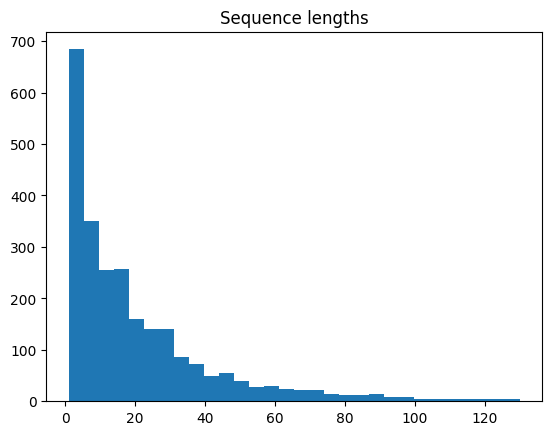

Fraction of all elements that are zero: 0.714
Number of sequences all-zero: 0
Zero rate per feature (first 10): [0.71404123 0.71404123 0.71404123 0.71404123]
raw seq length: 1
raw seq (first 3 rows):
 [[2. 1. 1. 3.]]
scaled seq (first 3 rows):
 [[ 1.9982799  -0.7543438  -1.3720684  -0.53461903]]
padded last 5 timesteps:
 tensor([[ 0.0000,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  0.0000],
        [ 1.9983, -0.7543, -1.3721, -0.5346]])


In [67]:
# 1) distribution of raw sequence lengths
lengths = [len(s) for s in X_cont_seq]
import numpy as np
print("n sequences:", len(lengths))
print("length percentiles (50/75/90/95/99):", np.percentile(lengths, [50,75,90,95,99]))

# 2) histogram
import matplotlib.pyplot as plt
plt.hist(lengths, bins=30); plt.title("Sequence lengths"); plt.show()

# 3) fraction of zeros in padded tensor
import torch
frac_zeros = (X_cont_padded == 0).float().mean().item()
print(f"Fraction of all elements that are zero: {frac_zeros:.3f}")

# 4) how many sequences are entirely zero after padding
all_zero_seq_count = (X_cont_padded.abs().sum(dim=(1,2)) == 0).sum().item()
print("Number of sequences all-zero:", all_zero_seq_count)

# 5) per-feature zero rate (average across samples & timesteps)
zero_rate_per_feature = ((X_cont_padded == 0).float().mean(dim=(0,1))).cpu().numpy()
print("Zero rate per feature (first 10):", zero_rate_per_feature[:10])

# 6) compare a raw sequence, scaled, and padded version (example index 0)
print("raw seq length:", len(X_cont_seq[0]))
print("raw seq (first 3 rows):\n", np.array(X_cont_seq[0])[:3])
print("scaled seq (first 3 rows):\n", np.array(X_cont_scaled[0])[:3])
print("padded last 5 timesteps:\n", X_cont_padded[0, -5:, :])

In [68]:
for xb_cont, xb_cat, yb in train_loader:
    # xb_cont: (batch, seq_len, n_cont), xb_cat: (batch, seq_len)
    print('cont:', xb_cont.dtype, xb_cont.min(), xb_cont.max())
    print('cat :', xb_cat.dtype, xb_cat.min(), xb_cat.max())
    print('y   :', yb.dtype, yb.min(), yb.max())
    break


cont: torch.float32 tensor(-4.9287) tensor(2.8938)
cat : torch.int64 tensor(0) tensor(5)
y   : torch.float32 tensor(0.) tensor(1.)


In [69]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
criterion = nn.BCELoss()

for epoch in range(10):
    model.train()
    for xb_cont, xb_cat, yb in train_loader:
        xb_cont = xb_cont.float()
        xb_cat = xb_cat.long()
        yb = yb.float()
        optimizer.zero_grad()
        preds = model(xb_cont, xb_cat).flatten()
        loss = criterion(preds, yb)
        loss.backward()
        optimizer.step()
    print("Epoch", epoch, "loss", float(loss))


Epoch 0 loss 0.6829400658607483
Epoch 1 loss 0.6109086275100708
Epoch 1 loss 0.6109086275100708
Epoch 2 loss 0.6454599499702454
Epoch 2 loss 0.6454599499702454
Epoch 3 loss 0.6387938857078552
Epoch 3 loss 0.6387938857078552
Epoch 4 loss 0.4961872696876526
Epoch 4 loss 0.4961872696876526
Epoch 5 loss 0.5193590521812439
Epoch 5 loss 0.5193590521812439
Epoch 6 loss 0.562701404094696
Epoch 6 loss 0.562701404094696
Epoch 7 loss 0.5596174597740173
Epoch 7 loss 0.5596174597740173
Epoch 8 loss 0.5844992399215698
Epoch 8 loss 0.5844992399215698
Epoch 9 loss 0.6441543102264404
Epoch 9 loss 0.6441543102264404
